<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Financial-Transactions" data-toc-modified-id="Financial-Transactions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Financial Transactions</a></span><ul class="toc-item"><li><span><a href="#The-Leaderboard-Predict-function" data-toc-modified-id="The-Leaderboard-Predict-function-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>The Leaderboard Predict function</a></span></li><li><span><a href="#Testing-your-Implementation" data-toc-modified-id="Testing-your-Implementation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Testing your Implementation</a></span></li></ul></li></ul></div>

# Financial Transactions

The ability to identify fraudulent transactions is of great interest to the payments industry. In this notebook, you will make use of the binary classifier you trained on the transcations dataset to detect fraud.

In [1]:
import os
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pathlib
import numpy as np

In [2]:
path = "./data" if os.path.exists("./data") else "."
data = pd.read_csv(os.path.join(path, "transactions.csv"))
X = data.drop("Class", axis=1)
y = data["Class"]
X_data = X.values
y_data = y.values

# split training data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# define algorithms for n-fold-cross validation
algorithms = [
    ('Logistic Regression', LogisticRegression(), {'C': [0.1, 0.5, 1.0, 5.0, 10.0]}),
    ('Decision Tree', DecisionTreeClassifier(), {'max_depth': [None, 3, 5, 8, 13]}),
    ('Random Forest', RandomForestClassifier(), {'n_estimators': [5, 10, 20]}),
    ('K-Nearest Neighbors', KNeighborsClassifier(), {'n_neighbors': [3, 5, 8, 13]}),
    ('Neural Network', MLPClassifier(max_iter=100, learning_rate_init=0.001), {'hidden_layer_sizes': [(50,), (20,20,), (10,10,10)]}),
]

In [3]:
def print_conf_matr(cm):
    fig, ax = plt.subplots(figsize=(8, 6))

    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    cbar = ax.figure.colorbar(im, ax=ax)

    classes = ['0', '1']  # Assuming class 0 and class 1
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    thresh = cm.max() / 2.0  # Threshold for text color
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

    plt.show()

In [4]:
def plot_specificity_sensitivity(model_names, cms):
    specificities = []
    sensitivities = []

    for cm in cms:
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        specificities.append(specificity)
        sensitivities.append(sensitivity)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(model_names, specificities, label='Specificity')
    ax.bar(model_names, sensitivities, label='Sensitivity')

    ax.set_title('Model Comparison - Specificity and Sensitivity')
    ax.set_xlabel('Model')
    ax.set_ylabel('Score')

    ax.legend()

    plt.xticks(rotation=45)

    plt.show()

def plot_accuracy(model_names, accuracy_scores):
    min_accuracy = min(accuracy_scores)
    y_min = min_accuracy - 0.01
    y_max = 1.0
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(model_names, accuracy_scores)

    ax.set_ylim([y_min, y_max])

    ax.set_title('Model Comparison - Accuracy')
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')

    plt.xticks(rotation=45)

    plt.show()

In [5]:
def train_model(name, model, param_grid):
    print(f"Estimating hyperparameters for {name}, using param grid {param_grid} ...")
    
    # estimate hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=n_fold)
    grid_search.fit(X_scaled, y_train)
    
    best_parameters = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"{name}")
    print(f"Best params: {best_parameters}, Accuracy: {best_score}")
    
    model.set_params(**best_parameters)
    
    print("Fitting models with best parameters...")
    model.fit(X_scaled, y_train)
    
    print(f'Fitted Model Parameters: {model.get_params()}\n')
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on testing data: {accuracy:.4f}\n")
    
    cm = confusion_matrix(y_test, y_pred)
    print_conf_matr(cm)
    return accuracy, cm


In [6]:
# Perform n-fold cross validation for each model to find hyperparameters

n_fold = 5

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

model_scores = []

log_reg = algorithms[0]
des_tree = algorithms[1]
rand_for = algorithms[2]
knn = algorithms[3]
mlp = algorithms[4]

Estimating hyperparameters for Logistic Regression, using param grid {'C': [0.1, 0.5, 1.0, 5.0, 10.0]} ...
Logistic Regression
Best params: {'C': 0.1}, Accuracy: 0.999133182856677
Fitting models with best parameters...
Fitted Model Parameters: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Accuracy on testing data: 0.9981



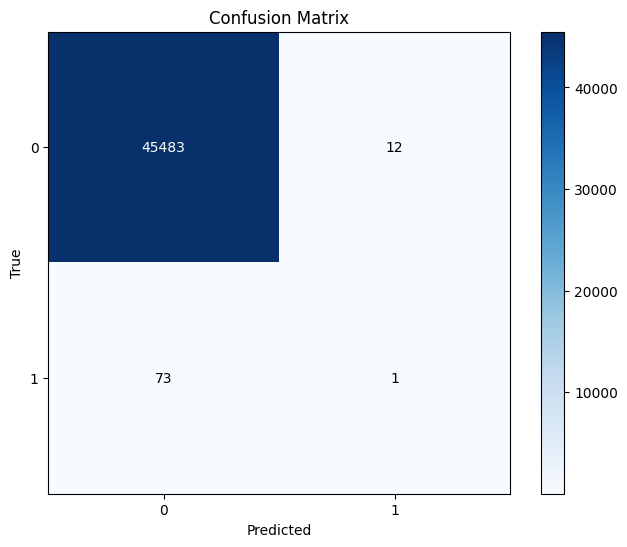

In [7]:
# Train logistic regression
l_n, l_m, l_p_g = log_reg
log_reg_acc, log_reg_cm = train_model(l_n, l_m, l_p_g)

model_scores.append((l_n, log_reg_acc, log_reg_cm))

Estimating hyperparameters for Decision Tree, using param grid {'max_depth': [None, 3, 5, 8, 13]} ...
Decision Tree
Best params: {'max_depth': 5}, Accuracy: 0.9994184639757302
Fitting models with best parameters...
Fitted Model Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Accuracy on testing data: 0.9995



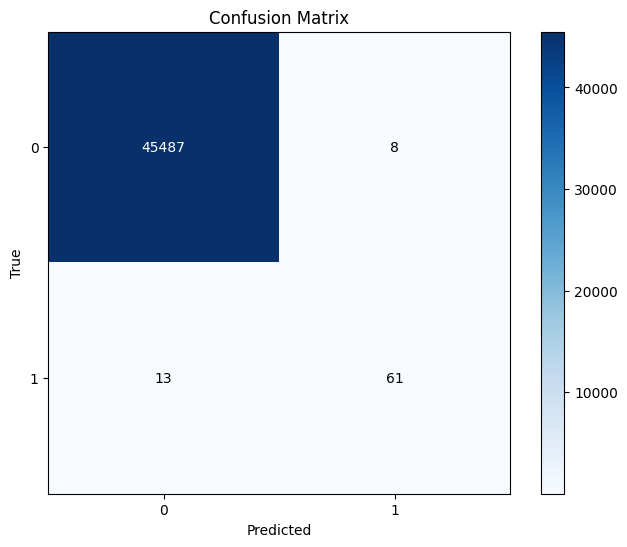

In [8]:
# Train desicion tree
d_n, d_m, d_p_g = des_tree
des_tree_acc, des_tree_cm = train_model(d_n, d_m, d_p_g)

model_scores.append((d_n, des_tree_acc, des_tree_cm))

Estimating hyperparameters for Random Forest, using param grid {'n_estimators': [5, 10, 20]} ...
Random Forest
Best params: {'n_estimators': 20}, Accuracy: 0.9994568674869082
Fitting models with best parameters...
Fitted Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Accuracy on testing data: 0.9996



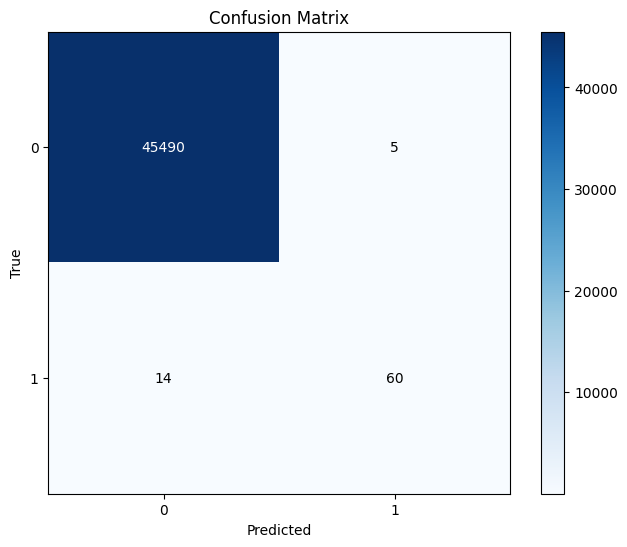

In [9]:
# Train random forest
r_n, r_m, r_p_g = rand_for
rand_for_acc, rand_for_cm = train_model(r_n, r_m, r_p_g)

model_scores.append((r_n, rand_for_acc, rand_for_cm))

Estimating hyperparameters for K-Nearest Neighbors, using param grid {'n_neighbors': [3, 5, 8, 13]} ...
K-Nearest Neighbors
Best params: {'n_neighbors': 3}, Accuracy: 0.9994349224728893
Fitting models with best parameters...
Fitted Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}

Accuracy on testing data: 0.9984



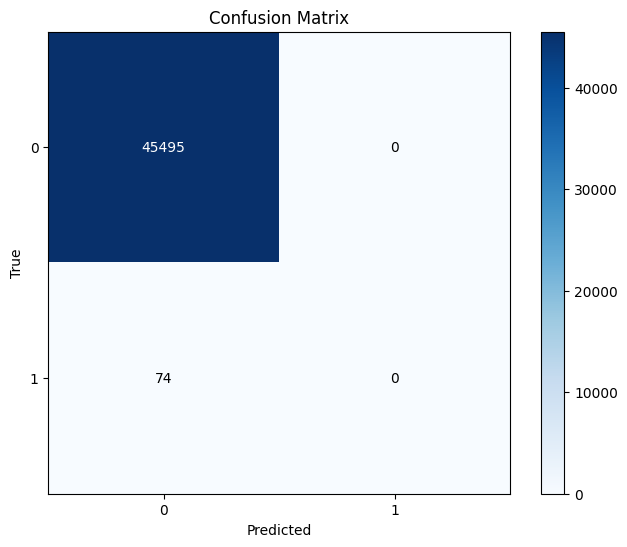

In [10]:
# Train knn
knn_n, knn_m, knn_p_g = knn
knn_acc, knn_cm = train_model(knn_n, knn_m, knn_p_g)

model_scores.append((knn_n, knn_acc, knn_cm))

Estimating hyperparameters for Neural Network, using param grid {'hidden_layer_sizes': [(50,), (20, 20), (10, 10, 10)]} ...
Neural Network
Best params: {'hidden_layer_sizes': (50,)}, Accuracy: 0.9993965194131771
Fitting models with best parameters...
Fitted Model Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 100, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

Accuracy on testing data: 0.9984



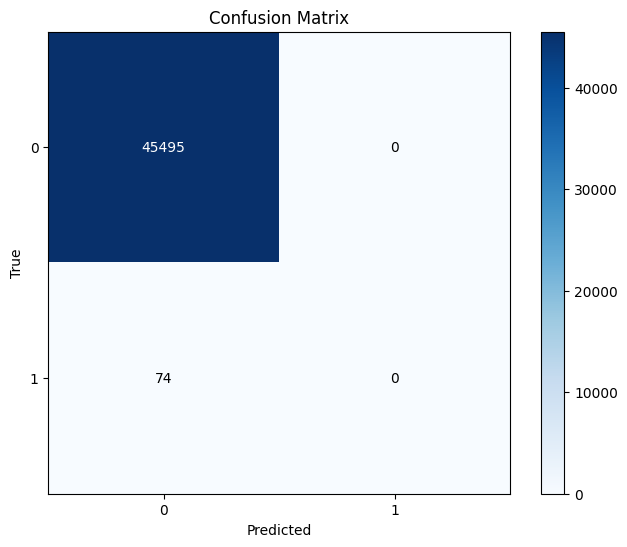

In [11]:
# Train mlp
mlp_n, mlp_m, mlp_p_g = mlp
mlp_acc, mlp_cm = train_model(mlp_n, mlp_m, mlp_p_g)

model_scores.append((mlp_n, mlp_acc, mlp_cm))

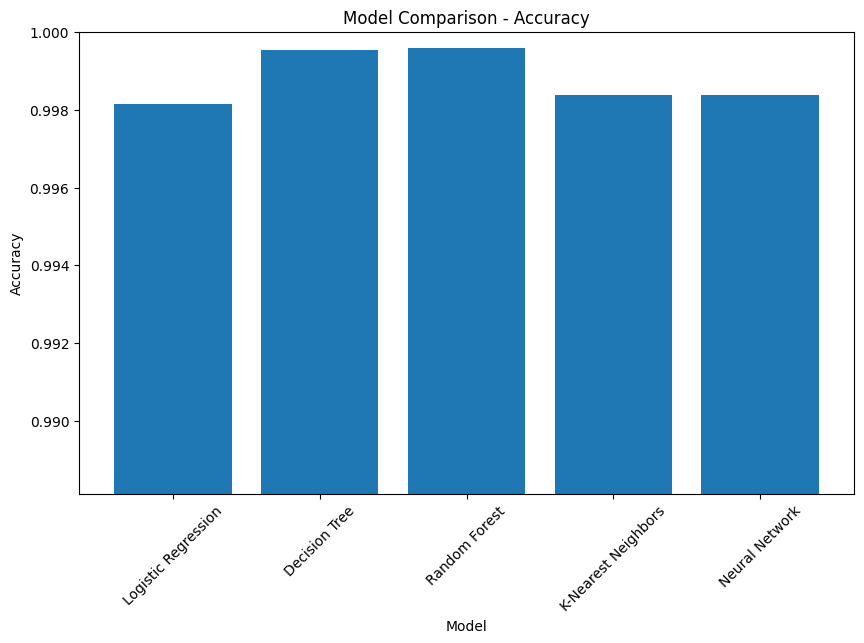

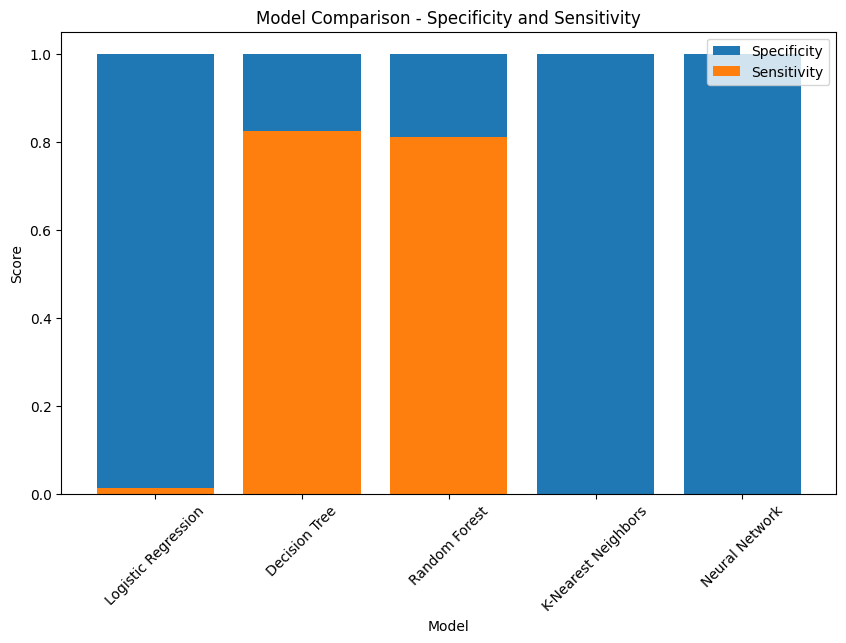

In [12]:
# Lastly, plot every method to see which one is best
model_names = [name for name, _, _ in model_scores]
accuracy_scores = [score for _, score, _ in model_scores]
cms = [cm for _, _, cm in model_scores]

plot_accuracy(model_names, accuracy_scores)
plot_specificity_sensitivity(model_names, cms)

## The Leaderboard Predict function
Replace the comment and `NotImplementedError` in the `leader_board_predict_fn` with code that loads your model parameters and returns the likelyhood of fraud for each transaction (i.e. row) in the values dataframe. Note that the returned array should contain a single decision function value for each transaction, indicating whether the transaction is fraudulent (i.e. it belongs to target class $1$). The higher the decision function value, the more likely that the transaction is fraud.
You can import the packages you require.

In [13]:
def leader_board_predict_fn(values):
    
    decision_function_values = r_m.predict(values)
    
    return decision_function_values

## Testing your Implementation
Your model should return the probability or decision function value that indicates the likelyhood of fraud for each input transaction. To verify that this is the case, we run your model on a subset of the transactions dataset it was trained on. There is a hidden cell that performs the actual test on the unseen test set and computes your score for the leaderboard using the [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) score.

In [15]:
def get_score():
    """
    Function to compute scores for train and test datasets.
    """

    import pandas as pd
    import numpy as np
    import os
    from sklearn.metrics import roc_auc_score
    import pathlib

    try:
        path = "./data/" if os.path.exists("./data") else "."
        test_data = pd.read_csv(os.path.join(path, "transactions.csv"))
        X_test = test_data.drop(columns = "Class")
        y_test = test_data["Class"]
        decision_function_values = leader_board_predict_fn(X_test)
        assert decision_function_values.shape == (X_test.shape[0],)
        dataset_score = roc_auc_score(y_test, decision_function_values)
        assert dataset_score >= 0.0 and dataset_score <= 1.0
    except Exception:
        dataset_score = float("nan")
    print(f"Train Dataset Score: {dataset_score}")

    import os
    import pwd
    import time
    import datetime
    import pandas as pd
    user_id = pwd.getpwuid( os.getuid() ).pw_name
    curtime = time.time()
    dt_now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

    try:
        HIDDEN_DATASET_PATH = os.path.expanduser("/data/mlproject22-test-data")
        test_data = pd.read_csv(os.path.join(HIDDEN_DATASET_PATH,"transactions_scoreboard.csv.zip"))
        X_test = test_data.drop(columns=["Class"])
        y_test = test_data["Class"]
        decision_function_values = leader_board_predict_fn(X_test)
        hiddendataset_score = roc_auc_score(y_test, decision_function_values)
        print(f"Test Dataset Score: {hiddendataset_score}")
        score_dict = dict(
            score_hidden=hiddendataset_score,
            score_train=dataset_score,
            unixtime=curtime,
            user=user_id,
            dt=dt_now,
            comment="",
        )
    except Exception as e:
        err = str(e)
        score_dict = dict(
            score_hidden=float("nan"),
            score_train=dataset_score,
            unixtime=curtime,
            user=user_id,
            dt=dt_now,
            comment=err
        )

    #if list(pathlib.Path(os.getcwd()).parents)[0].name == 'source':
    #    print("we are in the source directory... replacing values.")
    #    print(pd.DataFrame([score_dict]))
    #    score_dict["score_hidden"] = -1
    #    score_dict["score_train"] = -1
    #    print("new values:")
    #    print(pd.DataFrame([score_dict]))

    pd.DataFrame([score_dict]).to_csv("transactions.csv", index=False)
    
get_score()

/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Train Dataset Score: 0.8958555518188589


NameError: name 'score_dict' is not defined